In [88]:
# pip install -q stellargraph

In [89]:
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Data Preparation
Loading the CORA network

In [90]:
dataset = sg.datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

The info method can help us verify that our loaded graph matches the description:

In [91]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


We aim to train a graph-ML model that will predict the “subject” attribute on the nodes. These subjects are one of 7 categories, with some categories more common than others:

In [92]:
node_subjects.value_counts().to_frame()

,subject
Neural_Networks,818
Probabilistic_Methods,426
Genetic_Algorithms,418
Theory,351
Case_Based,298
Reinforcement_Learning,217
Rule_Learning,180


## Splitting the data
Dataset is spitted into the two subsets of nodes for the training, and rest for the validation and testing purpose.

In [93]:

train_subjects, test_subjects = model_selection.train_test_split(
    node_subjects, train_size=500, test_size=None, stratify=node_subjects
)
val_subjects, test_subjects = model_selection.train_test_split(
    test_subjects, train_size=700, test_size=None, stratify=test_subjects
)

using stratified sampling gives the following counts

In [94]:
train_subjects.value_counts().to_frame()

,subject
Neural_Networks,151
Probabilistic_Methods,79
Genetic_Algorithms,77
Theory,65
Case_Based,55
Reinforcement_Learning,40
Rule_Learning,33


## Converting to numeric arrays
Categorical target data is converted to the numerical arrays using a one-hot encoder, and it will be compared to the soft-max output of the model generated. The method called `LabelBinarizer()’ from scikit-learn is employed to perform this conversion.

In [95]:
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

# 2. Creating the GCN layers
Now graph convolution layer is created as per StellarGraph architecture, i.e., create a data generator for converting graph structure into matrix format that can be supplied as input to Keras model and design layers. `FullBatchNodeGenerator` class from StellarGraph is used as data generator 

In [96]:
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


A generator just encodes the information required to produce the model inputs. Calling the `flow` method with a set of nodes and their true labels produces an object that can be used to train the model, on those nodes and labels that were specified. 

In [97]:
train_gen = generator.flow(train_subjects.index, train_targets)

For layer design, `GCN’ class is used with some parameters as layer size for hidden layers, activation to be applied on the result of each GCN layer, and dropout rate. Here, the dropout rate as 0.5, and two hidden layers with size  64 and 32 are used.

In [98]:
gcn = GCN(
    layer_sizes=[64, 32], activations=["relu", "relu"], generator=generator, dropout=0.5
)

To create a Keras model we now expose the input and output tensors of the GCN model for node prediction, via the GCN.in_out_tensors method:

In [99]:
x_inp, x_out = gcn.in_out_tensors()

x_out

<tf.Tensor 'gather_indices_3/GatherV2:0' shape=(1, None, 32) dtype=float32>

The x_out value is a TensorFlow tensor that holds a 16-dimensional vector for the nodes requested when training or predicting. The actual predictions of each node’s class/subject needs to be computed from this vector. StellarGraph is built using Keras functionality, so this can be done with a standard Keras functionality: an additional dense layer (with one unit per class) using a softmax activation. This activation function ensures that the final outputs for each input node will be a vector of “probabilities”, where every value is between 0 and 1, and the whole vector sums to 1. The predicted class is the element with the highest value.

In [100]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

# 3. Training and evaluating

In [101]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)
model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(1, 2708, 1433)]    0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           [(1, None, 2)]       0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           [(1, None)]          0                                            
__________________________________________________________________________________________________
dropout_6 (Dropout)             (1, 2708, 1433)      0           input_13[0][0]                   
______________________________________________________________________________________

In [102]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [103]:

from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=50, restore_best_weights=True)

In [104]:

history = model.fit(
    train_gen,
    epochs=1000,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/1000
1/1 - 0s - loss: 1.9615 - acc: 0.0960 - val_loss: 1.8769 - val_acc: 0.3286
Epoch 2/1000
1/1 - 0s - loss: 1.8697 - acc: 0.3420 - val_loss: 1.7775 - val_acc: 0.3186
Epoch 3/1000
1/1 - 0s - loss: 1.7614 - acc: 0.3520 - val_loss: 1.6553 - val_acc: 0.3471
Epoch 4/1000
1/1 - 0s - loss: 1.6363 - acc: 0.3820 - val_loss: 1.5321 - val_acc: 0.4057
Epoch 5/1000
1/1 - 0s - loss: 1.4858 - acc: 0.4520 - val_loss: 1.3983 - val_acc: 0.4786
Epoch 6/1000
1/1 - 0s - loss: 1.3473 - acc: 0.5020 - val_loss: 1.2426 - val_acc: 0.5714
Epoch 7/1000
1/1 - 0s - loss: 1.1830 - acc: 0.5920 - val_loss: 1.0875 - val_acc: 0.6529
Epoch 8/1000
1/1 - 0s - loss: 1.0399 - acc: 0.6600 - val_loss: 0.9491 - val_acc: 0.7029
Epoch 9/1000
1/1 - 0s - loss: 0.8907 - acc: 0.7240 - val_loss: 0.8239 - val_acc: 0.7714
Epoch 10/1000
1/1 - 0s - loss: 0.7705 - acc: 0.7820 - val_loss: 0.7131 - val_acc: 0.8143
Epoch 11/1000
1/1 - 0s - loss: 0.6232 - acc: 0.8440 - val_loss: 0.6243 - val_acc: 0.8371
Epoch 12/1000
1/1 - 0s - loss:

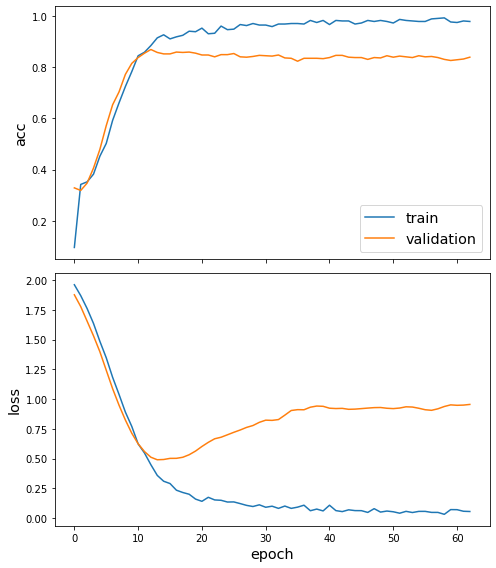

In [105]:
sg.utils.plot_history(history)

In [106]:
test_gen = generator.flow(test_subjects.index, test_targets)

In [107]:

test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 1ms/step - loss: 0.4656 - acc: 0.8654

Test Set Metrics:
	loss: 0.4656
	acc: 0.8654


# Making predictions with the model

In [108]:

all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)

In [109]:

node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

In [110]:

df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

,Predicted,True
31336,Neural_Networks,Neural_Networks
1061127,Rule_Learning,Rule_Learning
1106406,Reinforcement_Learning,Reinforcement_Learning
13195,Reinforcement_Learning,Reinforcement_Learning
37879,Probabilistic_Methods,Probabilistic_Methods
1126012,Probabilistic_Methods,Probabilistic_Methods
1107140,Reinforcement_Learning,Theory
1102850,Neural_Networks,Neural_Networks
31349,Neural_Networks,Neural_Networks
1106418,Theory,Theory


In [111]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [112]:
emb = embedding_model.predict(all_gen)
emb.shape

(1, 2708, 32)

In [113]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

transform = TSNE  # or PCA

In [114]:

X = emb.squeeze(0)
X.shape

(2708, 32)

In [115]:

trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
X_reduced.shape

(2708, 2)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'visualization of node embeddings for each documents of cora dataset'),
 None]

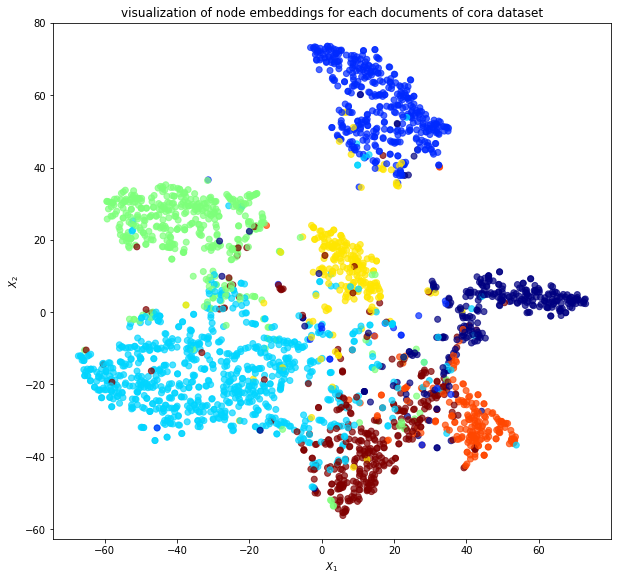

In [119]:

fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap="jet",
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"visualization of node embeddings for each documents of cora dataset",
)